# Homework 4

In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import random
import time

## Visualize data

We chose the Google web graph at https://snap.stanford.edu/data/web-Google.html.

In [2]:
stream = []

In [3]:
folder = 'data'
file = 'web-NotreDame.txt' # download from https://snap.stanford.edu/data/web-NotreDame.html

def read_graph(folder, file, steps=10000):
    with open(folder + '/' + file, 'r') as f:
        graph = nx.DiGraph()
        # skip first 4 lines
        for i in range(4):
            f.readline()
        # each line is an edge (pair of nodes)
        counter = 0
        for line in f:
            edge = line.split()
            stream.append((int(edge[0]), int(edge[1])))
            graph.add_edge(int(edge[0]), int(edge[1]))
            counter += 1
            if counter == steps:
                break
    return graph

In [4]:
G = read_graph(folder, file)

print("Number of nodes: ", G.number_of_nodes())
print("Number of edges: ", G.number_of_edges())

Number of nodes:  5720
Number of edges:  10000


In [5]:
# convert G to undirected graph
G_undirected = G.to_undirected()

print("Number of nodes: ", G_undirected.number_of_nodes())
print("Number of edges: ", G_undirected.number_of_edges())

Number of nodes:  5720
Number of edges:  9210


In [6]:
# calculate number of triangles
triangles = nx.triangles(G_undirected)

print("Number of triangles: ", sum(triangles.values()) / 3)

Number of triangles:  7825.0


## Streaming graph algorithm

We implemented the reservoir sampling used in the graph algorithm presented in the paper M. Jha, C. Seshadhri, and A. Pinar, [A Space-Efficient Streaming Algorithm for Estimating Transitivity and Triangle Counts Using the Birthday Parado](https://arxiv.org/pdf/1212.2264.pdf), ACM TKDD, 9-3, 2015.

In [7]:
edge_res = [] # list of edges (i, j)
wedge_res = [] # list of wedges (i, j, k)
isClosed = [] # boolean array
tot_wedges = 0 # this is the total number of wedges formed by edges in the current edge res

def clean():
    global edge_res, wedge_res, isClosed, tot_wedges

    edge_res = []
    wedge_res = []
    isClosed = []
    tot_wedges = 0

def closed_by(wedge, edge):
    if edge[0] == wedge[2] and edge[1] == wedge[0]:
        return True
    return False

def update_tot_wedges():
    global tot_wedges

    for i in range(len(edge_res)):
        for j in range(i + 1, len(edge_res)):
            intersection = set(edge_res[i]).intersection(set(edge_res[j]))
            # if len(intersection) == 1 and (edge_res[i][1] == edge_res[j][0] or edge_res[i][0] == edge_res[j][1]):
            if len(intersection) == 1:
                tot_wedges += 1

def calculate_N_t(edge_t):
    N_t_list = []

    for i in range(len(edge_res)):
        intersection = set(edge_t).intersection(set(edge_res[i]))
        # if len(intersection) == 1 and (edge_res[i][1] == edge_t[0] or edge_res[i][0] == edge_t[1]):
        if len(intersection) == 1:
            N_t_list.append(i)

    return N_t_list

def streaming_triangles(s_e, s_w):
    global edge_res, wedge_res, tot_wedges

    k_t = [] # transitivity (global clustering coefficient) at time t
    T_t = [] # number of triangles at time t
    time_list = [] # time

    # initialize edge_res, wedge_res with size s_e, s_w
    for i in range(s_e):
        edge_res.append((0, 0))
    for i in range(s_w):
        wedge_res.append((0, 0, 0))
        isClosed.append(False)

    for edge_t, t in zip(stream, range(1, len(stream) + 1)):
        time_start = time.time()

        # print("=====================================")
        # print("taking edge", edge_t, "at time", t)

        # time.sleep(2) # sleep for 2 seconds to simulate streaming

        tot_wedges = 0
        
        update(edge_t, s_e, s_w, t)
        # print("edge_res", edge_res)
        # print("wedge_res", wedge_res)
        # print("isClosed", isClosed)
        # count the fraction of entries in isClosed set to true
        p = sum(isClosed) / len(isClosed) if len(isClosed) != 0 else 0
        # print("p", p)
        k_t.append(3 * p)
        # print("k_t", k_t[t-1])
        # print("(p * (t * t))", (p * (t * t)))
        # print("s_e", s_e)
        # print("(s_e * (s_e - 1))", (s_e * (s_e - 1)))
        # print("tot_wedges", tot_wedges)
        T_t.append(((p * (t * t)) / (s_e * (s_e - 1))) * tot_wedges)

        time_list.append(time.time() - time_start)

    return T_t, time_list

def update(edge_t, s_e, s_w, t):
    global isClosed, tot_wedges, edge_res, wedge_res

    for i in range(s_w):
        if closed_by(wedge_res[i], edge_t):
            isClosed[i] = True

    edge_res_old = edge_res.copy()

    for i in range(s_e):
        # pick a random number from 0 to 1
        x = random.random()
        if x <= 1 / t:
            edge_res[i] = edge_t
        # if there were any updates of edge res
    if edge_res != edge_res_old:
        # update tot_wedges, the number of wedges formed by edge_res
        update_tot_wedges()
        N_t_list = calculate_N_t(edge_t)
        # print("N_t_list", N_t_list)
        new_wedges = len(N_t_list)

        for i in range(s_w):
            x = random.random()
            ratio = new_wedges / tot_wedges if tot_wedges != 0 else 0
            if x <= ratio:
                wedge_res[i] = (edge_t[0], edge_res[i][0], edge_res[i][1])
                wedge_res[i] = (edge_res[i][0], edge_res[i][1], edge_t[1])
                # pick uniform random wedge in N_t_list
                w = random.randint(0, len(N_t_list) - 1)
                # print("w", w)
                index = N_t_list[w]
                # print("N_t_list[w]", N_t_list[w])
                if edge_t[1] == edge_res[index][0]:
                    wedge_res[i] = (edge_t[0], edge_t[1], edge_res[index][1])
                else:
                    wedge_res[i] = (edge_res[index][0], edge_t[0], edge_t[1])
                isClosed[i] = False

In [8]:
# stream = [(1, 2), (1, 3), (4, 1), (2, 3), (2, 4), (3, 4)]

clean()

E = G.number_of_edges()
sample_size = E * 0.01 # 1% of E (suggested by the paper)
print("sample_size", int(E))

T_t, time_list = streaming_triangles(s_e=int(sample_size)*2, s_w=int(sample_size))

mean_T = sum(T_t) / len([x for x in T_t if x != 0])

print("Number of triangles: ", sum(triangles.values()) / 3)

print("Approx. number of triangles (T_t mean): ", mean_T)

T_t

sample_size 10000
Number of triangles:  7825.0
Approx. number of triangles (T_t mean):  3703.895543847772


[0.0,
 1.477537688442211,
 3.4265035175879395,
 6.31718592964824,
 10.244711055276383,
 14.813909547738696,
 20.200434673366832,
 26.597065326633167,
 33.34173693467337,
 41.61763819095477,
 50.14051507537688,
 60.05234170854271,
 70.98254773869347,
 82.8193567839196,
 91.15891959798995,
 104.04496080402009,
 116.43069346733668,
 130.1092010050251,
 135.72330150753768,
 141.2708542713568,
 136.8485050251256,
 134.1421809045226,
 132.6587123115578,
 137.77587135678394,
 143.87421482412063,
 150.96421809045228,
 159.28393567839194,
 166.86986934673368,
 176.7874974874372,
 188.81005025125629,
 197.18367839195983,
 206.61001005025128,
 219.22773919597992,
 232.76147135678391,
 240.43395100502514,
 252.91505125628143,
 256.98125025125626,
 268.42980402010045,
 284.33375276381906,
 297.7543718592965,
 313.8925386934673,
 322.5819708542713,
 333.50803241206034,
 335.5992763819095,
 339.95069095477385,
 348.5285929648241,
 355.29933417085425,
 349.6696281407035,
 360.76714145728636,
 360.3429

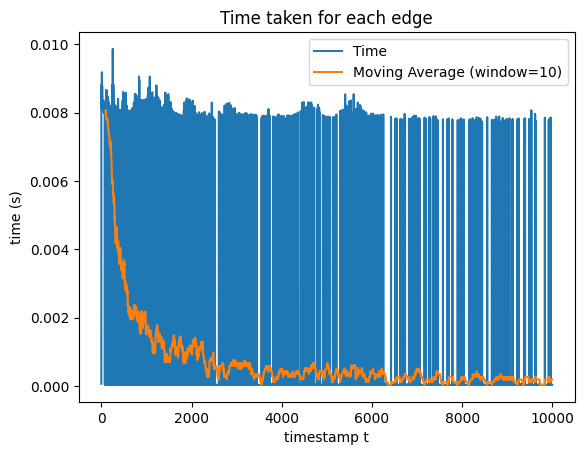

In [9]:
# plot time
rolling_avg = pd.Series(time_list).rolling(window=100).mean()
plt.plot(time_list, label='Time')
plt.plot(rolling_avg, label='Moving Average (window=10)')
plt.xlabel('timestamp t')
plt.ylabel('time (s)')
plt.title('Time taken for each edge')
plt.legend()
plt.show()

## Observations

We collected the following observations:
- Diminishing s_w results in lowering the chances to close a triangle. When n_w approaches 0 then we're not estimating at all, we're just outputting 0 as an estimate
- Reducing s_e lowers the chances to create a new wedge, that in turn lowers the chances to close a triangle. When s_e approaches 0 then we're not adding any wedge at all
- When we fix s_w, and we reduce s_e, we're lowering the chances to create a new wedge, but we're also lowering the chances to close a triangle. This is because we're not adding new wedges, but we're also not closing the ones we already have. That's why we picked s_e bigger than s_w, specifically two times bigger. That means the pace at which we're adding edges is twice the pace at which we're closing triangles. This is a good balance because we're not adding too many edges, but we're also not closing too many triangles. This is the best balance we found to maximize the number of triangles closed

## Final questions

1. What were the challenges you faced when implementing the algorithm? The challenge was to find the right balance between s_e and s_w. We tried different values and we found that s_e = 2*s_w is the best balance to maximize the number of triangles closed. We wanted to keep these values as small as possible to reduce the space and time complexity of the algorithm. Then we proceeded with 1% as it was a recommendation in the paper.
2. Can the algorithm be easily parallelized? If yes, how? If not, why? Explain. The only thing we need to do is to sum the two arrays at the end of the parallelization. Similarly to Apache Spark, we can distribute the algorithm on multiple clusters and then sum (collect) the results at the end on the "master" node.
3. Does the algorithm work for unbounded graph streams? Explain. No, because if the graph is unbounded, it means that the number of triangles is infinite and no matter which s_e and s_w we choose, we will never be able to close all the triangles. Furthermore, we cannot estimate E anymore, or better, E is infinite. Therefore the 1% of infinite is still infinite, s_e and s_w are also infinite and the algorithm will never stop.
4. Does the algorithm support edge deletions? If not, what modification would it need? Explain. Yes. Let's explain it with an example. Let's say we read 0-2 edge in the past and we closed a triangle with 0-1-2, therefore we set isClosed[0-1-2]=True. If we now delete 0-2 we would expect isClosed[0-1-2] as False, but this is going to happen naturally because of the nature of the algorithm. In fact, for each new wedge we received since the closure of triangle 0-1-2, the wedge 0-1-2 could have potentially been replaced by the new ones, and therefore set as False (=desired property/what we expect).
5. OUR QUESTION Can the algorithm support multiple incoming edges? Yes, because for both edge_res and wedge_res we are trying to save the current edge or wedge in each position of the two array. Therefore, if a overwriting occurs, due to multiple incoming edges, we are safe since we are not losing any information.

## Curiosities

- The approx. number of triangles in the graph is abs(E)^1/2, where E is the number of edges in the graph (https://math.stackexchange.com/questions/823481/number-of-triangles-in-a-graph-based-on-number-of-edges)